# Bengali.Al Handwritten Graphemes Classification

## Team: Zzz...
## Members: Cheng Zeng, Zhi Wang, Zhe Huang

--------------------------------------------------------------------------------------------------------------

# Introduction

This midterm project aims to develop a CNN model to classify the three constituent components of Bengali handwritten characters, including grapheme root, vowel diacritics, and consonant diacritics. Identifying characters by optical recognition is challenging since each Bengali has 11 vowels and 38 consonants in its alphabet, and there are 10 potential diacritics. As a result, a large amount of graphemes (the smallest units in a written language) exist. This quickly adds up to more than 10,000 different grapheme variations. This is a Kaggle competition, of which more information can be found in their website ([Kaggle link](https://www.kaggle.com/c/bengaliai-cv19)). This work by Team **Zzz..** now lives on [github](https://github.com/cengc13/Bengali_Kaggle). 

# Exploratory Data Analysis (EDA)

## Overview of the Bengali Grepheme Images

In [2]:
import os
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
import time, sys
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

sys.path.append("./tools")
from helpers import (get_n, get_dummies, resize, image_from_char, 
                     plot_count, display_image_from_data,
                    display_writting_variety, crop_resize)

In [3]:
for dirname, _, filenames in os.walk('../data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/test_image_data_3.parquet
../data/train.csv
../data/test_image_data_1.parquet
../data/train_image_data_2.parquet
../data/train_image_data_3.parquet
../data/test_image_data_2.parquet
../data/test_image_data_0.parquet
../data/train_image_data_0.parquet
../data/class_map.csv
../data/test.csv
../data/train_image_data_1.parquet
../data/sample_submission.csv
../data/Kalpurush_Fonts/kalpurush-2.ttf


We look at the **.csv* files 

### Trainingset 

In [6]:
### training dataframe
DATA_FOLDER = '../data'
train_df = pd.read_csv(os.path.join(DATA_FOLDER, 'train.csv'))
print(train_df.shape)
train_df.head()

(200840, 5)


,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


Note that the input is the handwritten image (the last column), while the output should be the classes for the corresponding three constituent components. In the *train.csv* file, there are 200,840 training images. 

### Toy testingset

In [7]:
### Testing dataframe
test_df = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))
print(test_df.shape)
test_df.head()

(36, 3)


,row_id,image_id,component
0,Test_0_consonant_diacritic,Test_0,consonant_diacritic
1,Test_0_grapheme_root,Test_0,grapheme_root
2,Test_0_vowel_diacritic,Test_0,vowel_diacritic
3,Test_1_consonant_diacritic,Test_1,consonant_diacritic
4,Test_1_grapheme_root,Test_1,grapheme_root


The testing images consist of 12 images whose constitutent components are listed as independent rows.

### Class map

In [8]:
### Classes for three components
class_map_df = pd.read_csv(os.path.join(DATA_FOLDER, 'class_map.csv'))
print(class_map_df.shape)
class_map_df.head()

(186, 3)


,component_type,label,component
0,grapheme_root,0,ং
1,grapheme_root,1,ঃ
2,grapheme_root,2,অ
3,grapheme_root,3,আ
4,grapheme_root,4,ই


### Submission format

In [9]:
### Example of submission format
sample_submission_df = pd.read_csv(os.path.join(DATA_FOLDER, 'sample_submission.csv'))
sample_submission_df.head()

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,0
2,Test_0_vowel_diacritic,0
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,0


The submission format is smilar to the testing dataset.

### Image pixels

Followed we will discuss the dataformat of the parquet files. We only deal with one of the training and testing parquet file.

In [10]:
train_0_df = pd.read_parquet(os.path.join(DATA_FOLDER,'train_image_data_0.parquet'))
print(train_0_df.shape)
train_0_df.head()

(50210, 32333)


,image_id,0,1,2,3,4,5,6,7,8,...,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,Train_0,254,253,252,253,251,252,253,251,251,...,253,253,253,253,253,253,253,253,253,251
1,Train_1,251,244,238,245,248,246,246,247,251,...,255,255,255,255,255,255,255,255,255,254
2,Train_2,251,250,249,250,249,245,247,252,252,...,254,253,252,252,253,253,253,253,251,249
3,Train_3,247,247,249,253,253,252,251,251,250,...,254,254,254,254,254,253,253,252,251,252
4,Train_4,249,248,246,246,248,244,242,242,229,...,255,255,255,255,255,255,255,255,255,255


Each train_image_data_x (x = 0...3) contains 50210 rows and 32333 columns - size of each image being: (137, 236). Totally there are 50210 x 4 = 200840 rows in the training set, in consistent the number of images in the train.csv file. Each feature corresponds to a pixel of the image. The values are in the range of $[0,255]$.

#### Pixel distribution

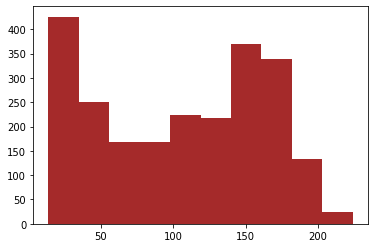

In [11]:
pixels_train_0 = 255 - train_0_df.iloc[7, 1:].values
plt.hist(pixels_train_0[pixels_train_0 > 13], color='brown');

## Data distribution 

### Number of Unique values 

In [17]:
print(f"Train: unique grapheme roots: {train_df.grapheme_root.nunique()}")
print(f"Train: unique vowel diacritics: {train_df.vowel_diacritic.nunique()}")
print(f"Train: unique consonant diacritics: {train_df.consonant_diacritic.nunique()}")
print(f"Train: total unique elements: {train_df.grapheme_root.nunique() + train_df.vowel_diacritic.nunique() + train_df.consonant_diacritic.nunique()}")
print(f"Class map: unique elements: \n{class_map_df.component_type.value_counts()}")
print(f"Total combinations: {pd.DataFrame(train_df.groupby(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'])).shape[0]}")

Train: unique grapheme roots: 168
Train: unique vowel diacritics: 11
Train: unique consonant diacritics: 7
Train: total unique elements: 186
Class map: unique elements: 
grapheme_root          168
vowel_diacritic         11
consonant_diacritic      7
Name: component_type, dtype: int64
Total combinations: 1292


### Class frequency analysis

####  Top 20 Grapheme roots and their percentages in training set

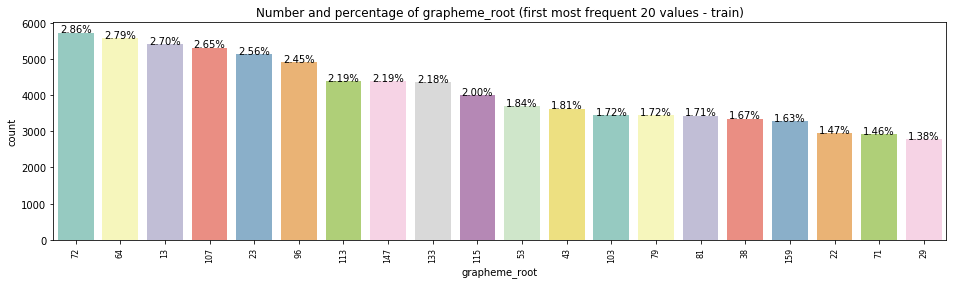

In [14]:
plot_count('grapheme_root', 'grapheme_root (first most frequent 20 values - train)', train_df, size=4)

####  Vowel diacritic percentages in the trainingset

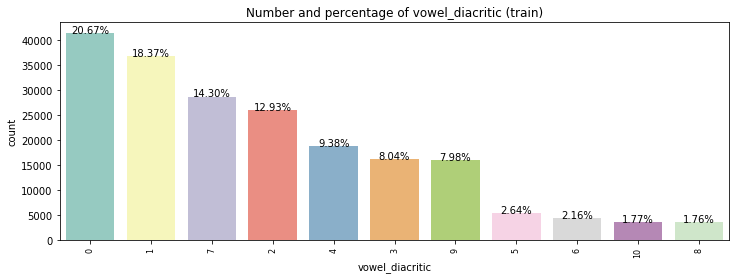

In [15]:
plot_count('vowel_diacritic', 'vowel_diacritic (train)', train_df, size=3)

####  Consonant diacritic percentages in the trainingset

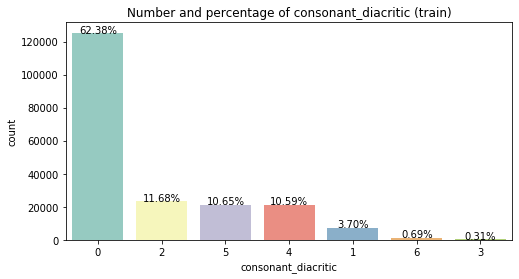

In [16]:
plot_count('consonant_diacritic', 'consonant_diacritic (train)', train_df, size=2)

According to the bar plots, the grapheme roots are more evenly distributed than both vowel diacritics and consonant diascritcs. Vowel diacritics tend to concentrate on class 0, 1, 7 and 2, whereas most of cosonant diacritics (more than 60\%) fall into class 0. 

##  Inspecting training images

###  25 randomly sampled images

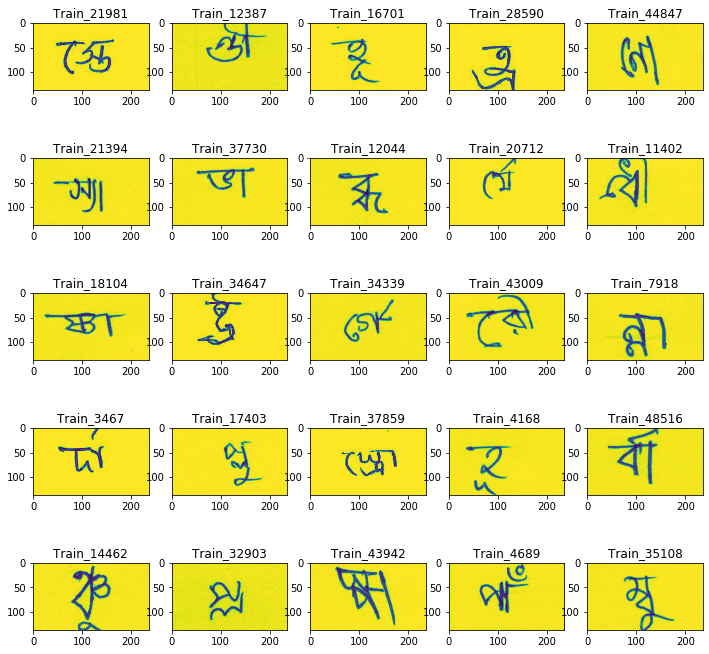

In [18]:
display_image_from_data(train_0_df.sample(25, random_state=42))

###  Studying writing variety

total: (163, 5)
total: (36, 32333)
grapheme: দাঁ, grapheme root: দ, vowel discritic: া, consonant diacritic: ঁ


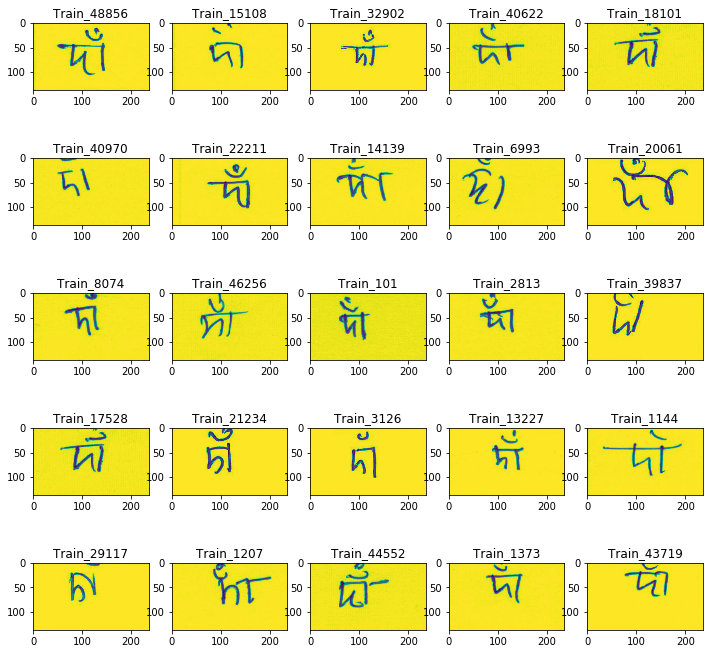

In [19]:
display_writting_variety(train_0_df,train_df, class_map_df,72,1,1,5)

##  Image crop and resize

Compare the resize methods provided in the `opencv` package and the resize method written by [lafoss](https://www.kaggle.com/iafoss/image-preprocessing-128x128). Both methods use the first eight images in training set for presentation.

### Methods by lafoss

In [20]:
HEIGHT = 137
WIDTH = 236
SIZE = 128

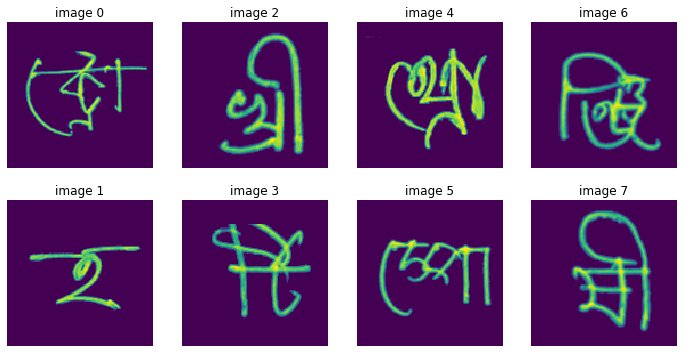

In [22]:
n_imgs = 8
fig, axs = plt.subplots(2, n_imgs//2, figsize=(n_imgs*1.5, 6))

for idx in range(n_imgs):
    #somehow the original input is inverted
    img0 = 255 - train_0_df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype(np.uint8)
    #normalize each image by its max val
    img = (img0*(255.0/img0.max())).astype(np.uint8)
    img = crop_resize(img, size=SIZE)

    axs[idx%2, idx//2].imshow(img)
    axs[idx%2, idx//2].set_title('image '+str(idx))
    axs[idx%2, idx//2].axis('off')
plt.show()

Check the pixel distribution after crop and resize

(array([387., 285., 244., 281., 279., 315., 518., 457., 220.,  60.]),
 array([ 14. ,  36.9,  59.8,  82.7, 105.6, 128.5, 151.4, 174.3, 197.2,
        220.1, 243. ]),
 <a list of 10 Patch objects>)

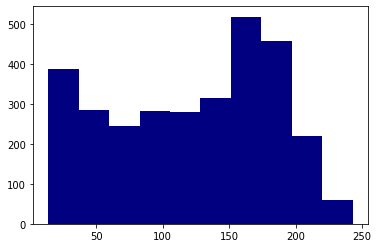

In [23]:
arrayvalues = img.reshape(-1)
plt.hist(arrayvalues[arrayvalues > 13], color='navy')

In [24]:
train_df = train_df.drop(['grapheme'], axis=1, inplace=False)

In [25]:
train_df_new = pd.merge(pd.read_parquet(DATA_FOLDER + f'/train_image_data_{0}.parquet')[:10], 
                    train_df, on='image_id').drop(['image_id'], axis=1)

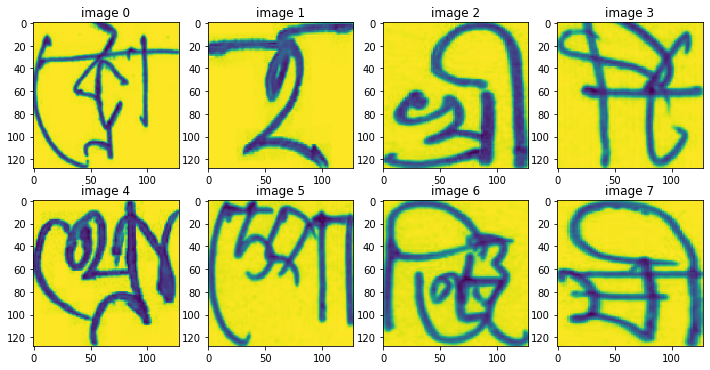

In [28]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
count=0
for row in ax:
    for col in row:
        col.imshow(resize(train_df_new.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1).iloc[[count]], size=SIZE, 
                          plain=False, need_progress_bar=False)\
                   .values.reshape(-1).reshape(SIZE, SIZE).astype(np.float64))
        col.set_title("image " + str(count))
        count += 1
plt.show()

/home/hughes/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/hughes/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([640., 319., 253., 257., 299., 314., 385., 847., 605.,  99.]),
 array([ 14. ,  37.1,  60.2,  83.3, 106.4, 129.5, 152.6, 175.7, 198.8,
        221.9, 245. ]),
 <a list of 10 Patch objects>)

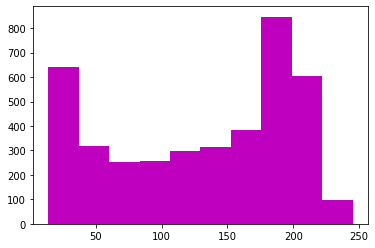

In [29]:
array_7 = 255 - resize(train_df_new.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1).iloc[[count]], 
       size=128, plain=False, need_progress_bar=False)
plt.hist(array_7[array_7 > 13], color='m')

As we can see, both resize methods are relible since the figures after crop and resize look normal and the the original pixel distribution is mostly preserved.

# The model

In [30]:
# %tensorflow_version 2.x 
# On Colab, need this to specify tensorflow version
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from glob import glob
import time, gc, sys
import cv2

DATA_FOLDER = "../data"
directory = "./tools"
sys.path.append(directory)
from helpers import (get_n, get_dummies, resize, plot_loss,
                     MultiOutputDataGenerator, plot_acc,
                    image_from_char)

In [45]:
## Function for customized augmentation methods
## shiftscalerotate and cutout are used.
import albumentations as A
def cutout_shiftscalerotate(image):
    if len(image.shape) > 2:
        width, height, _ = image.shape
    else:
        width, height = image.shape
    aug=A.Compose(
        [
         A.ShiftScaleRotate(shift_limit=0.15, scale_limit=0.15, 
        rotate_limit=4, border_mode=cv2.BORDER_REFLECT_101, p=0.6),
        A.Cutout(num_holes=1, max_h_size=width//2, max_w_size=height//2,
             fill_value=1.0, p=0.4)
        ]                     
        )
    image = aug(image=image)['image']
    return image
# make sure you have the latest version 0.4.3, if not 
# update it using '!pip3 install albumentations==0.4.3'
A.__version__

'0.4.3'

In [32]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Input, Activation, Concatenate
from tensorflow.keras.layers import MaxPool2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.initializers import RandomNormal
# you can import different NN architectures here
from tensorflow.keras.applications import DenseNet121, DenseNet169
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [33]:
import os
for dirname, _, filenames in os.walk(DATA_FOLDER):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/test_image_data_3.parquet
../data/train.csv
../data/test_image_data_1.parquet
../data/train_image_data_2.parquet
../data/train_image_data_3.parquet
../data/test_image_data_2.parquet
../data/test_image_data_0.parquet
../data/train_image_data_0.parquet
../data/class_map.csv
../data/test.csv
../data/train_image_data_1.parquet
../data/sample_submission.csv
../data/Kalpurush_Fonts/kalpurush-2.ttf


In [34]:
train_df_ = pd.read_csv(DATA_FOLDER+'/train.csv')
test_df_ = pd.read_csv(DATA_FOLDER + '/test.csv')
class_map_df = pd.read_csv(DATA_FOLDER + '/class_map.csv')
sample_sub_df = pd.read_csv(DATA_FOLDER + '/sample_submission.csv')

In [35]:
train_df_ = train_df_.drop(['grapheme'], axis=1, inplace=False)

In [36]:
train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']] = train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].astype('uint8')

In [48]:
# resize image size
IMG_SIZE=128
# IMG_SIZE=64
N_CHANNELS=1

## Densenet121

In [38]:
def build_densenet(SIZE, rate=0.3):
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, 1))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(rate)(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(rate)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(rate)(x)

    # multi output
    grapheme_root = Dense(168, activation = 'softmax', name='root')(x)
    vowel_diacritic = Dense(11, activation = 'softmax', name='vowel')(x)
    consonant_diacritic = Dense(7, activation = 'softmax', name='consonant')(x)

    # model
    model = Model(inputs=input, outputs=[grapheme_root, vowel_diacritic, consonant_diacritic])
    
    return model

In [39]:
model = build_densenet(SIZE=IMG_SIZE, rate=0.3)

In [40]:
# add l1 regularizer into layers 
regularizer = tf.keras.regularizers.l1(1e-3)
for layer in model.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
          setattr(layer, attr, regularizer)

# set the glorot_normal initializer
initializer = keras.initializers.glorot_normal(seed=None)
for layer in model.layers:
    for attr in ['kernel_initializer']:
        if hasattr(layer, attr):
            setattr(layer, attr, initializer)

In [41]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 3)  30          input_2[0][0]                    
__________________________________________________________________________________________________
densenet121 (Model)             multiple             7037504     conv2d[0][0]                     
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 1024)         0           densenet121[1][0]                
______________________________________________________________________________________________

In [42]:
weights = {'root': 0.4, 'vowel': 0.3, 'consonant':0.3}
# lr = 1e-3
# opt = keras.optimizers.RMSprop(learning_rate=lr, rho=0.9)
model.compile(optimizer=Adam(lr=0.00016), loss='categorical_crossentropy', 
              loss_weights=weights, metrics=['accuracy'])

In [43]:
# Learning rate will be half after 3 epochs if accuracy is not increased
lr_scheduler = []
targets = ['root', 'vowel', 'consonant']
for target in targets:
    lr_scheduler.append(ReduceLROnPlateau(monitor=f'{target}_accuracy', 
                                            patience=3,
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001))

# Callback : Save best model
cp = ModelCheckpoint('saved_models/densenet121_128x128_1-rr.h5',
                           monitor = 'val_root_accuracy',
                           save_best_only = True,
                           save_weights_only = False,
                           mode = 'auto',
#                            save_freq = 1,
                           verbose = 0)
# Callback : Early Stop
es = EarlyStopping(monitor='val_root_accuracy',
                          mode = 'auto',
                          patience = 4,
                          min_delta = 0,
                          verbose = 1)

cb = [*lr_scheduler, cp]

In [44]:
# batch_size = 512
batch_size = 64
epochs = 30

HEIGHT = 137
WIDTH = 236

In [ ]:
histories = []
# for i in range(4):
for i in range(1):
    train_df = pd.merge(pd.read_parquet(DATA_FOLDER + f'/train_image_data_{i}.parquet'), train_df_, on='image_id').drop(['image_id'], axis=1)

    X_train = train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1)
    X_train = resize(X_train, size=IMG_SIZE, plain=False)/255

    # CNN takes images in shape `(batch_size, h, w, channels)`, so reshape the images
    X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)

    Y_train_root = pd.get_dummies(train_df['grapheme_root']).values
    Y_train_vowel = pd.get_dummies(train_df['vowel_diacritic']).values
    Y_train_consonant = pd.get_dummies(train_df['consonant_diacritic']).values

    print(f'Training images: {X_train.shape}')
    print(f'Training labels root: {Y_train_root.shape}')
    print(f'Training labels vowel: {Y_train_vowel.shape}')
    print(f'Training labels consonants: {Y_train_consonant.shape}')


    # Divide the data into training and validation set
    x_train, x_test, y_train_root, y_test_root, y_train_vowel, y_test_vowel, y_train_consonant, y_test_consonant = \
    train_test_split(X_train, Y_train_root, Y_train_vowel, Y_train_consonant, test_size=0.08, random_state=66)
    del train_df
    del X_train
    del Y_train_root, Y_train_vowel, Y_train_consonant

    # Data augmentation for creating more training data
    datagen = MultiOutputDataGenerator(
        preprocessing_function = cutout_shiftscalerotate
        )


    # This will just calculate parameters required to augment the given data. This won't perform any augmentations
    datagen.fit(x_train)

    # Fit the model
    history = model.fit(datagen.flow(x_train, {'root': y_train_root, 'vowel':y_train_vowel, 'consonant': y_train_consonant}, 
                                batch_size=batch_size),
                        epochs = epochs, validation_data = (x_test, [y_test_root, y_test_vowel, y_test_consonant]), 
                        steps_per_epoch=x_train.shape[0] // batch_size, 
                        callbacks=cb)
    #                           callbacks=[learning_rate_reduction_root, learning_rate_reduction_vowel, learning_rate_reduction_consonant])

    histories.append(history)

    # Delete to reduce memory usage
    del x_train
    del x_test
    del y_train_root
    del y_test_root
    del y_train_vowel
    del y_test_vowel
    del y_train_consonant
    del y_test_consonant
    gc.collect()

In [ ]:
for dataset in range(1):
    plot_loss(histories[dataset], epochs, f'Training Dataset: {dataset}')
    plot_acc(histories[dataset], epochs, f'Training Dataset: {dataset}')

In [ ]:
del histories
gc.collect()

# Inference and Submission

In [46]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import cv2
from math import ceil

from tensorflow import keras
from sklearn.model_selection import train_test_split
import os

Original image size

In [47]:
WIDTH = 236
HEIGHT = 137

Resized image size

In [ ]:
IMG_SIZE=128
N_CHANNELS=1

Suppose after training, we have two models saved in the same directory with filenames of 
"densenet121_128x128_1.h5" and "densenet121_128x128_2.h5". Then we can load the models and
make predictions.

In [ ]:
trainedmodel2 = "./densenet121_128x128_2.h5"
trainedmodel1 = "./densenet121_128x128_1.h5"
model1 = keras.models.load_model(trainedmodel1)
model2 = keras.models.load_model(trainedmodel2)

In [49]:
# batch_size for data generator
BATCH_SIZE = 24
# Dir
DIR = '../data'

In [50]:
class TestDataGenerator(keras.utils.Sequence):
    def __init__(self, X, batch_size = 16, img_size = (512, 512, 3), *args, **kwargs):
        self.X = X
        self.indices = np.arange(len(self.X))
        self.batch_size = batch_size
        self.img_size = img_size
                    
    def __len__(self):
        return int(ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X = self.__data_generation(indices)
        return X
    
    def __data_generation(self, indices):
        X = np.empty((self.batch_size, *self.img_size))
        
        for i, index in enumerate(indices):
            image = self.X[index]
            image = np.stack((image,)*N_CHANNELS, axis=-1)
            image = image.reshape(-1, HEIGHT_NEW, WIDTH_NEW, N_CHANNELS)
            
            X[i,] = image
        
        return X

In [52]:
# Using single image resize to reduce memory consumption
def resize_image(img, WIDTH_NEW, HEIGHT_NEW):
    image = img.reshape(HEIGHT, WIDTH)
    _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

    idx = 0
    ls_xmin = []
    ls_ymin = []
    ls_xmax = []
    ls_ymax = []
    for cnt in contours:
        idx += 1
        x,y,w,h = cv2.boundingRect(cnt)
        ls_xmin.append(x)
        ls_ymin.append(y)
        ls_xmax.append(x + w)
        ls_ymax.append(y + h)
    xmin = min(ls_xmin)
    ymin = min(ls_ymin)
    xmax = max(ls_xmax)
    ymax = max(ls_ymax)

    roi = image[ymin:ymax,xmin:xmax]
    image_resized = cv2.resize(roi, (WIDTH_NEW, HEIGHT_NEW), interpolation = cv2.INTER_AREA)
    image_resized = (image_resized/255).astype(np.float16)

    return image_resized.reshape(-1)

In [53]:
# Create Submission File
tgt_cols = ['grapheme_root','vowel_diacritic','consonant_diacritic']

# Create Predictions
row_ids, targets = [], []

In [ ]:
### Loop through Test Parquet files (X)
## Do this cell for four times while changing dataset by specifying i = 1, 2, or 3
i = 0 
# Test Files Placeholder
test_files = []

# Read Parquet file
df = pd.read_parquet(os.path.join(DIR, 'test_image_data_'+str(i)+'.parquet'))
# Get Image Id values
image_ids = df['image_id'].values 
# Drop Image_id column
df = df.drop(['image_id'], axis = 1)
df.astype(np.uint8)
# Loop over rows in Dataframe and generate images 
#specify data type as `np.float16` to save memory since default is `np.float64`
X = np.empty([df.shape[0], int(WIDTH_NEW*HEIGHT_NEW)], dtype=np.float16)
for image_id, index in zip(image_ids, range(df.shape[0])):
    test_files.append(image_id)
    roi = resize_image(df.loc[df.index[index]].values, WIDTH_NEW, HEIGHT_NEW)
    X[index,:] = roi
roi = None 
df = None
del roi
del df
gc.collect()
# Data_Generator
data_generator_test = TestDataGenerator(X, batch_size = BATCH_SIZE, img_size = (HEIGHT_NEW, WIDTH_NEW, N_CHANNELS))

# Predict with all 3 models
preds1 = model1.predict_generator(data_generator_test)
preds2 = model2.predict_generator(data_generator_test)
# preds3 = model3.predict_generator(data_generator_test)

# Loop over Preds
for i, image_id in enumerate(test_files):
    for subi, col in zip(range(len(preds1)), tgt_cols):
        sub_preds1 = preds1[subi]
        sub_preds2 = preds2[subi]
#         sub_preds3 = preds3[subi]

        # Set Prediction with average of 5 predictions
        row_ids.append(image_id+'_'+col)
        ## ensemble prediction
        sub_pred_value = np.argmax(sub_preds1[i] + sub_preds2[i])
#         sub_pred_value = np.argmax(sub_preds1[i])
        targets.append(sub_pred_value)

# Cleanup
data_generator_test = None
preds1 = None
preds2 = None
X = None
del data_generator_test
del preds1
del X
del test_files
gc.collect()

In [54]:
# Create and Save Submission File
submit_df = pd.DataFrame({'row_id':row_ids,'target':targets}, columns = ['row_id','target'])
submit_df.to_csv('submission.csv', index = False)
print(submit_df.head(40))

Empty DataFrame
Columns: [row_id, target]
Index: []


### Baseline accuracy 

The baseline accuracy of three components are $1/unque\_values$. So the baseline accuracies for Grapheme roots, vowel diacritic and consonant diascritic are $1/168$, $1/11$, $1/7$, respectively.

## References 

- Most of the codes in this notbook are copied from two kernels by [Kaushal Shah](https://www.kaggle.com/kaushal2896/bengali-graphemes-starter-eda-multi-output-cnn) and [Gabriel Preda](https://www.kaggle.com/gpreda/bengali-ai-handwritten-grapheme-getting-started)